In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold

# from skmultilearn.model_selection import iterative_train_test_split

import warnings
warnings.simplefilter("ignore")

from pathlib import Path

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

In [28]:
from pptoolbox.monitor import MonitorV3Trainer

# import data

In [29]:
version = "v2"

import_folder = Path("../data/processed") / version / "full"

X = pd.read_csv(import_folder / "input.csv", index_col=0)
y = pd.read_csv(import_folder / "label.csv", index_col=0)
y_meta = pd.read_csv(import_folder / "meta.csv", index_col=0)

print(f"Shapes of X, y, y_meta: {X.shape}, {y.shape}, {y_meta.shape}")

Shapes of X, y, y_meta: (342, 191), (342, 1), (342, 4)


In [30]:
y['Condition'].value_counts()

Condition
MDD         158
Controls    132
BD           34
BPD          18
Name: count, dtype: int64

## remove the BD and BPD
there are too little bd and bpd samples so I am removing them

In [31]:
to_remove = y['Condition'].isin(['BD', 'BPD'])
X_2class = X.copy().loc[~to_remove]
y_2class = y.copy().loc[~to_remove]
y_meta_2class = y_meta.copy().loc[~to_remove]

print(f"Shapes of X, y, y_meta: {X_2class.shape}, {y_2class.shape}, {y_meta_2class.shape}")

Shapes of X, y, y_meta: (290, 191), (290, 1), (290, 4)


# check that samples are sorted by date

In [32]:
def sort_all_by_date(X, y, y_meta):

    X = X.reset_index()
    y = y.reset_index()
    y_meta = y_meta.reset_index()

    sorted_indices = y_meta.sort_values('date_scanned').index
    X_sorted = X.loc[sorted_indices]
    y_sorted = y.loc[sorted_indices]
    y_meta_sorted = y_meta.loc[sorted_indices]

    X_sorted = X_sorted.set_index('lot_id')
    y_sorted = y_sorted.set_index('lot_id')
    y_meta_sorted = y_meta_sorted.set_index('lot_id')
    
    return X_sorted, y_sorted, y_meta_sorted

In [33]:
try:
    assert y_meta_2class['date_scanned'].is_monotonic_increasing, "samples not sorted by date"
except AssertionError as e:
    print(e)
    print("Sorting samples by date...")
    X_2class_sorted, y_2class_sorted, y_meta_2class_sorted = sort_all_by_date(X_2class, y_2class, y_meta_2class)
    assert y_meta_2class_sorted['date_scanned'].is_monotonic_increasing
    assert y_2class_sorted.index.equals(y_meta_2class_sorted.index) and X_2class_sorted.index.equals(y_meta_2class_sorted.index)

samples not sorted by date
Sorting samples by date...


# split by time

In [34]:
# Function to split last 20% as test set for each category
def split_last_20_percent(group):
    test_size = int(len(group) * 0.2)  # 20% of the group

    # ensure that test set has at least 1 sample from each category
    if test_size == 0:
        test_size = 1

    test_idx = group.iloc[-test_size:]  # Last 20% as test set
    train_idx = group.iloc[:-test_size]  # Remaining 80% as train set
    train_ids = train_idx.index
    test_ids = test_idx.index
    return train_ids, test_ids

In [35]:
y_2class_sorted_nodup = y_2class_sorted[~y_2class_sorted.index.duplicated(keep='first')]
y_2class_sorted_nodup.value_counts()

Condition
MDD          76
Controls     65
Name: count, dtype: int64

In [36]:
# Apply function to each Rancidity category
train_ids, test_ids = zip(*y_2class_sorted_nodup.groupby('Condition').apply(split_last_20_percent))

# Combine train and test indices
train_ids = np.concatenate(train_ids)
test_ids = np.concatenate(test_ids)

# Check if train and test indices are disjoint
assert set(train_ids).isdisjoint(set(test_ids)), "Train and test sets are not disjoint"

# print shape of train and test indices
print(len(set(train_ids)), len(set(test_ids)))

113 28


In [37]:
X_train_time = X_2class_sorted.copy()[X_2class_sorted.index.isin(train_ids)]
y_train_time = y_2class_sorted.copy()[y_2class_sorted.index.isin(train_ids)]
y_meta_train_time = y_meta_2class_sorted.copy()[y_meta_2class_sorted.index.isin(train_ids)]

X_test_time = X_2class_sorted.copy()[X_2class_sorted.index.isin(test_ids)]
y_test_time = y_2class_sorted.copy()[y_2class_sorted.index.isin(test_ids)]
y_meta_test_time = y_meta_2class_sorted.copy()[y_meta_2class_sorted.index.isin(test_ids)]

In [38]:
y_train_time[~y_train_time.index.duplicated(keep='first')].value_counts(), y_test_time[~y_test_time.index.duplicated(keep='first')].value_counts()

(Condition
 MDD          61
 Controls     52
 Name: count, dtype: int64,
 Condition
 MDD          15
 Controls     13
 Name: count, dtype: int64)

In [39]:
output_dir_time = Path("../data/processed") / version / f"{version}.0"
output_dir_time.mkdir(parents=True, exist_ok=True)
print(f"Saving to {output_dir_time}")

Saving to ..\data\processed\v2\v2.0


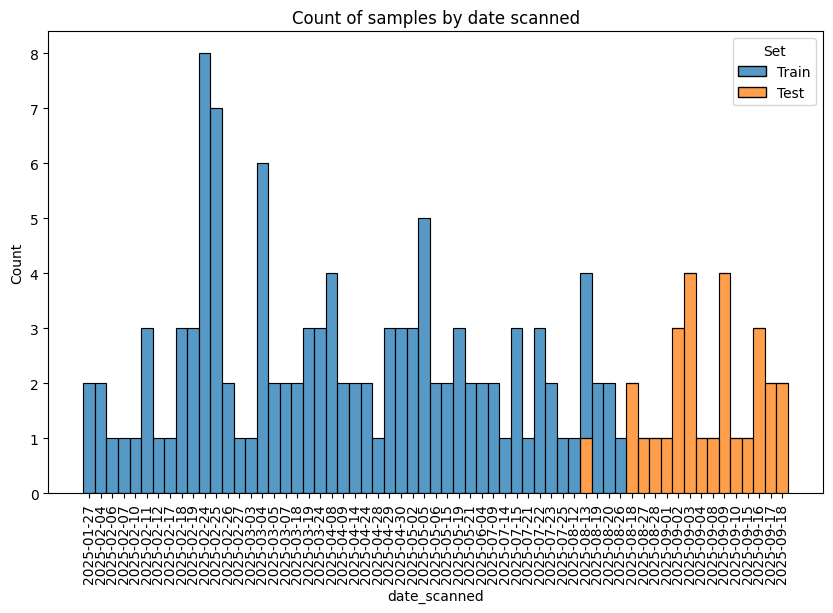

In [40]:
y_combined_time = pd.concat([y_train_time, y_test_time])
y_combined_meta_time = pd.concat([y_meta_train_time, y_meta_test_time])

assert all(y_combined_time.index == y_combined_meta_time.index), "Indices do not match!"

y_allinfo_time = pd.concat([y_combined_time, y_combined_meta_time], axis=1)
y_allinfo_time['Set'] = ['Train'] * len(y_train_time) + ['Test'] * len(y_test_time)

y_allinfo_nodup = y_allinfo_time[~y_allinfo_time.index.duplicated(keep='first')]

fig = plt.figure(figsize=(10, 6))
# Force integer y-ticks
from matplotlib.ticker import MaxNLocator
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

sns.histplot(data=y_allinfo_nodup, x='date_scanned', hue='Set', multiple="stack")
plt.xticks(rotation=90)
plt.title('Count of samples by date scanned')

fig.savefig(output_dir_time / "time_split.png", bbox_inches='tight')

In [16]:
train_folder = output_dir_time / "train"
train_folder.mkdir(parents=True, exist_ok=True)

X_train_time.to_csv(train_folder / "input.csv")
y_train_time.to_csv(train_folder / "label.csv")
y_meta_train_time.to_csv(train_folder / "meta.csv")

test_folder = output_dir_time / "test"
test_folder.mkdir(parents=True, exist_ok=True)

X_test_time.to_csv(test_folder / "input.csv")
y_test_time.to_csv(test_folder / "label.csv")
y_meta_test_time.to_csv(test_folder / "meta.csv")

# train test split random

In [41]:
cv = StratifiedGroupKFold(n_splits=5)

train_idx, test_idx = next(cv.split(X_2class, y_2class, groups = y_meta_2class.index))

train_ids = y_2class.iloc[train_idx].index
test_ids = y_2class.iloc[test_idx].index

# print shape of train and test indices
print(len(set(train_ids)), len(set(test_ids)))

assert set(train_ids).isdisjoint(set(test_ids)), "Train and test sets are not disjoint"

113 28


In [42]:
X_train_random = X_2class.copy()[X_2class.index.isin(train_ids)]
X_test_random = X_2class.copy()[X_2class.index.isin(test_ids)]
y_train_random = y_2class.copy()[y_2class.index.isin(train_ids)]
y_test_random = y_2class.copy()[y_2class.index.isin(test_ids)]
y_meta_train_random = y_meta_2class.copy()[y_meta_2class.index.isin(train_ids)]
y_meta_test_random = y_meta_2class.copy()[y_meta_2class.index.isin(test_ids)]

In [43]:
y_train_random[~y_train_random.index.duplicated(keep='first')].value_counts(), y_test_random[~y_test_random.index.duplicated(keep='first')].value_counts()

(Condition
 MDD          61
 Controls     52
 Name: count, dtype: int64,
 Condition
 MDD          15
 Controls     13
 Name: count, dtype: int64)

In [44]:
output_dir_random = Path("../data/processed") / version / f"{version}.1"
output_dir_random.mkdir(parents=True, exist_ok=True)
print(f"Saving to {output_dir_random}")

Saving to ..\data\processed\v2\v2.1


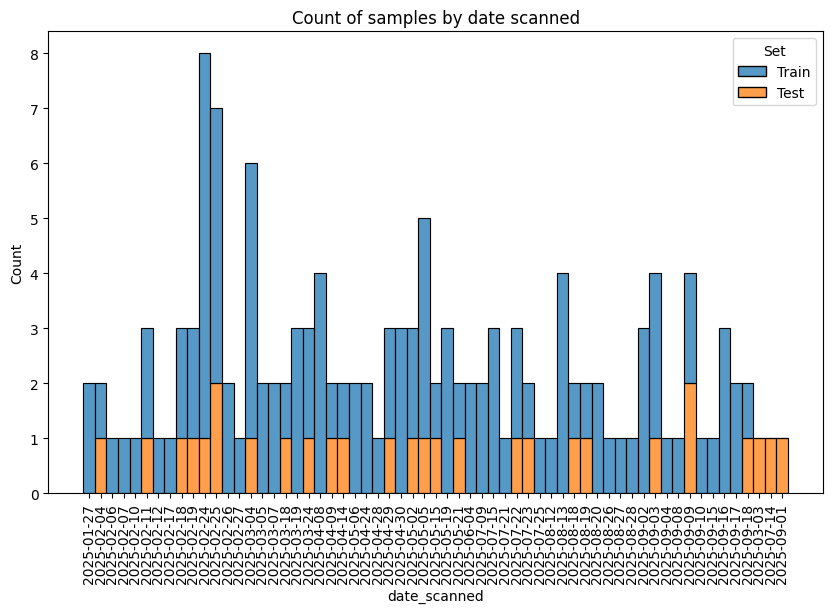

In [45]:
y_combined_random = pd.concat([y_train_random, y_test_random])
y_combined_meta_random = pd.concat([y_meta_train_random, y_meta_test_random])

assert all(y_combined_random.index == y_combined_meta_random.index), "Indices do not match!"

y_allinfo_random = pd.concat([y_combined_random, y_combined_meta_random], axis=1)
y_allinfo_random['Set'] = ['Train'] * len(y_train_random) + ['Test'] * len(y_test_random)

y_allinfo_nodup = y_allinfo_random[~y_allinfo_random.index.duplicated(keep='first')]

fig = plt.figure(figsize=(10, 6))
# Force integer y-ticks
from matplotlib.ticker import MaxNLocator
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

sns.histplot(data=y_allinfo_nodup, x='date_scanned', hue='Set', multiple="stack")
plt.xticks(rotation=90)
plt.title('Count of samples by date scanned')

fig.savefig(output_dir_random / "random_split.png", bbox_inches='tight')

In [26]:
train_folder = output_dir_random / "train"
train_folder.mkdir(parents=True, exist_ok=True)

X_train_random.to_csv(train_folder / "input.csv")
y_train_random.to_csv(train_folder / "label.csv")
y_meta_train_random.to_csv(train_folder / "meta.csv")

test_folder = output_dir_random / "test"
test_folder.mkdir(parents=True, exist_ok=True)

X_test_random.to_csv(test_folder / "input.csv")
y_test_random.to_csv(test_folder / "label.csv")
y_meta_test_random.to_csv(test_folder / "meta.csv")

# monitor comparison
to check for stability and drift

In [46]:
tsplit_monitor = MonitorV3Trainer()
tsplit_monitor.fit(X_train_time)
tsplit_pipeline = tsplit_monitor.get_pipeline()
tsplit_preds = tsplit_pipeline.predict(X_test_time)
tsplit_preds_lot = tsplit_preds.copy().groupby(tsplit_preds.index).mean()

rsplit_monitor = MonitorV3Trainer()
rsplit_monitor.fit(X_train_random)
rsplit_pipeline = rsplit_monitor.get_pipeline()
rsplit_preds = rsplit_pipeline.predict(X_test_random)
rsplit_preds_lot = rsplit_preds.copy().groupby(rsplit_preds.index).mean()

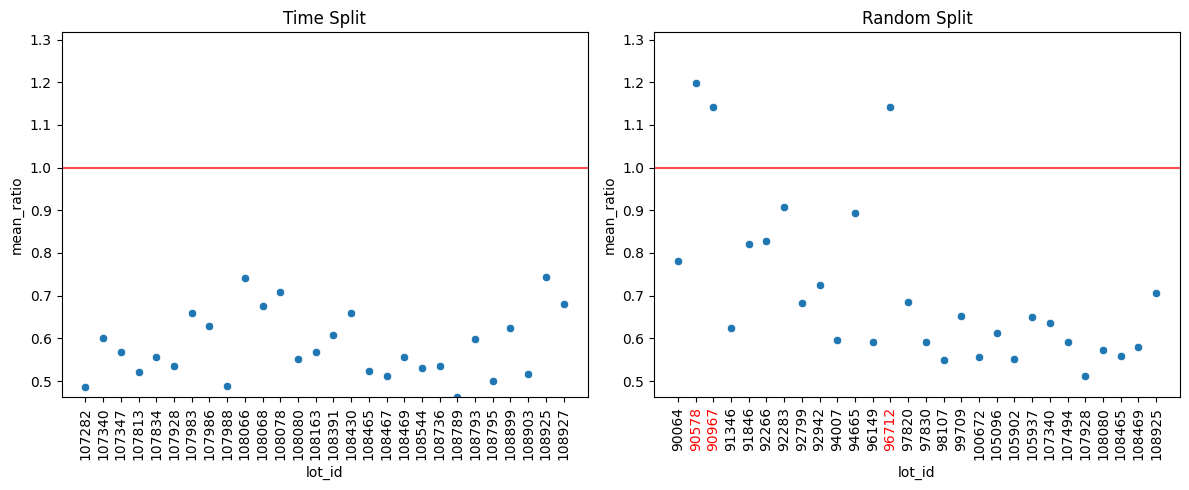

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Create 1 row, 2 columns of subplots

# Get the combined y-axis range for both datasets
y_min = min(tsplit_preds_lot['mean_ratio'].min(), rsplit_preds_lot['mean_ratio'].min())
y_max = max(tsplit_preds_lot['mean_ratio'].max(), rsplit_preds_lot['mean_ratio'].max())
y_max = y_max*1.1

# Plot time split
sns.scatterplot(ax=ax[0], x=tsplit_preds_lot.index.astype(str), y=tsplit_preds_lot['mean_ratio'])
ax[0].set_title('Time Split')
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_ylim(y_min, y_max)
ax[0].axhline(y=1.0, color='red', linestyle='-', alpha=0.7)

# Plot random split
sns.scatterplot(ax=ax[1], x=rsplit_preds_lot.index.astype(str), y=rsplit_preds_lot['mean_ratio'])
ax[1].set_title('Random Split')
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_ylim(y_min, y_max)
ax[1].axhline(y=1.0, color='red', linestyle='-', alpha=0.7)

# highlight the x_axis labels for any data point with y-value more than 1.0
for i, a in enumerate(ax):
    if i == 0:  # Time split
        data = tsplit_preds_lot
    else:  # Random split
        data = rsplit_preds_lot
    
    # Get x-tick labels and positions
    tick_labels = a.get_xticklabels()
    
    for label in tick_labels:
        lot_id = int(label.get_text())
        # Check if this lot_id exists in data and has mean_ratio > 1.0
        if lot_id in data.index and data.loc[lot_id, 'mean_ratio'] > 1.0:
            label.set_color('red')

plt.tight_layout()
plt.show()

comparison_output_dir = Path("../data/processed") / version
comparison_output_dir.mkdir(parents=True, exist_ok=True)
fig.savefig(comparison_output_dir / "time_vs_random_split.png", bbox_inches='tight')